## Basic Regression - Predict fuel efficiency

<br>

- 지금까지는 회귀분석 을 중점으로 했었음.
- 회귀의 목적은 추세 파악 + 회귀식(선)을 기준으로 추세를 예측해 보는 것.
    - 즉 가격이나 확률과 같은 연속적인 출력값을 예측하는 것이 목적.
- Auto MPG 데이터 셋을 사용해 1970~1980년 대의 자동차 연비를 예측해보는 모델을 만들어보자.

In [1]:
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

In [4]:
# GPU를 써봅시다. 어제 등록해놨으니 사용할수 있겠지?
print(tf.test.gpu_device_name())
# print(tf.test.is_gpu_available()) # deprecated. Use `tf.config.list_physical_devices('GPU')` instead.
print(tf.config.list_physical_devices('GPU'))

/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Dataset load

In [5]:
dataset_path = keras.utils.get_file('auto-mpg.data', 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
dataset_path

32768/30286 [================================] - 0s 4us/step


'C:\\Users\\skdbs\\.keras\\datasets\\auto-mpg.data'

In [7]:
col_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
             'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=col_names,
                          na_values='?', comment='\t', sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Data Cleansing

In [8]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [9]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

    Horsepower에 결측값이 있다. 지우는 방법으로 선택.

In [10]:
dataset = dataset.dropna()

    또한 Origin은 수치형이 아닌 범주형. 
    One-hot encoding을 하자.

In [11]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Train / Test split

In [14]:
train_set = dataset.sample(frac=0.8, random_state=0)
test_set = dataset.drop(train_set.index)
print(train_set)
print(test_set)

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
146  28.0          4          90.0        75.0  2125.0          14.5   
282  22.3          4         140.0        88.0  2890.0          17.3   
69   12.0          8         350.0       160.0  4456.0          13.5   
378  38.0          4         105.0        63.0  2125.0          14.7   
331  33.8          4          97.0        67.0  2145.0          18.0   
..    ...        ...           ...         ...     ...           ...   
281  19.8          6         200.0        85.0  2990.0          18.2   
229  16.0          8         400.0       180.0  4220.0          11.1   
150  26.0          4         108.0        93.0  2391.0          15.5   
145  32.0          4          83.0        61.0  2003.0          19.0   
182  28.0          4         107.0        86.0  2464.0          15.5   

     Model Year  USA  Europe  Japan  
146          74  1.0     0.0    0.0  
282          79  1.0     0.0    0.0  
69           72  1.0 

### Simple EDA

<br>

- sns의 산점도 행렬을 통해 데이터를 한번 둘러보자.

C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['gulim'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


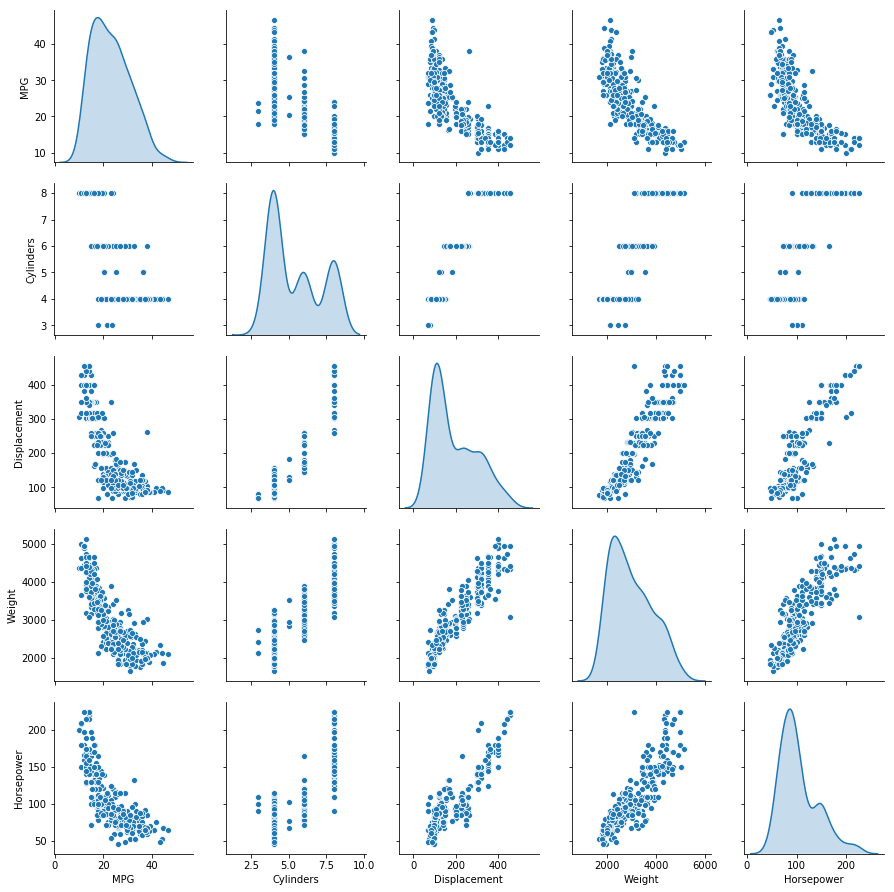

In [15]:
sns.pairplot(train_set[['MPG', 'Cylinders', 'Displacement', 'Weight', 'Horsepower']], diag_kind='kde')

    Cylinders는 이산형 변수로 보임.
    목표 변수인 MPG에 따른 Displacement, Weight, Horsepower가 어느정도 관계가 있어보임.
    다른 변수들도 서로 관계가 있어보인다.

In [16]:
train_stats = train_set.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


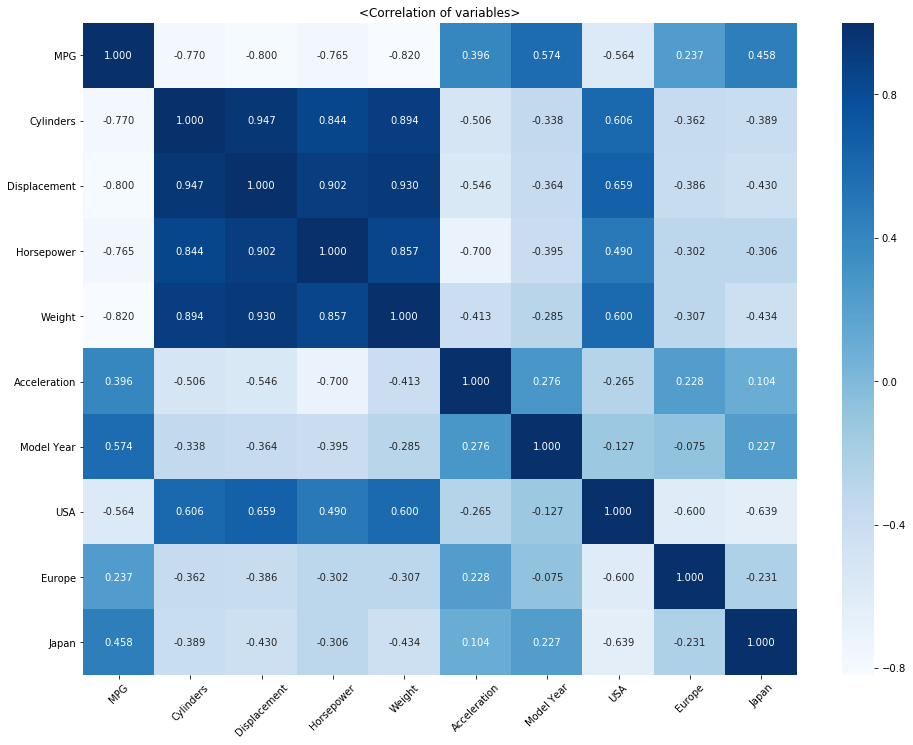

In [18]:
plt.figure(figsize=(16, 12))
heatMap = sns.heatmap(data=train_set.corr(), annot = True, fmt='.3f', cmap='Blues')
heatMap.set_xticklabels(heatMap.get_xticklabels(), rotation=45)
plt.title('<Correlation of variables>')
plt.show()

### Target Label 분리

<br>

- 타겟 값이 될 라벨 분리. 
- 이 라벨을 예측하기 위해 모델을 훈련시키는 것.

In [19]:
train_labels = train_set.pop('MPG')
test_labels = test_set.pop('MPG')

### Normalization

<br>

- 기술통계량을 확인해보니, 각 특성들의 범위가 제각각임.
- 이 상태로 훈련시키면 모델 학습성능이 많이 안좋아짐.
    - 모델이 수렴할 수 있긴 함. 근데 훈련이 상당히 어렵고 입력단위에 의존적이게 된다.
    - 그냥 정규화 합시다.

In [20]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_set)
normed_test_data = norm(test_set)

In [23]:
normed_train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852


    아래의 방법으로도 정규화를 진행할 수 있다고 합니다.
    영어 doc은 위 방법을 추천하지 않음.
    
  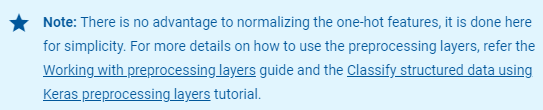
    

In [24]:
from tensorflow.keras.layers.experimental import preprocessing

normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_set))

In [25]:
print(normalizer.mean.numpy())

[5.4777069e+00 1.9531847e+02 1.0486943e+02 2.9902517e+03 1.5559236e+01
 7.5898087e+01 6.2420380e-01 1.7834395e-01 1.9745223e-01]


In [27]:
# test도 같이 노말라이징 하자.
normalizer.adapt(np.array(test_set))
test_set # ? 뭐지

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
9,8,390.0,190.0,3850.0,8.5,70,1.0,0.0,0.0
25,8,360.0,215.0,4615.0,14.0,70,1.0,0.0,0.0
28,8,304.0,193.0,4732.0,18.5,70,1.0,0.0,0.0
31,4,113.0,95.0,2228.0,14.0,71,0.0,0.0,1.0
33,6,232.0,100.0,2634.0,13.0,71,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
369,4,112.0,88.0,2395.0,18.0,82,1.0,0.0,0.0
375,4,105.0,74.0,1980.0,15.3,82,0.0,1.0,0.0
382,4,108.0,70.0,2245.0,16.9,82,0.0,0.0,1.0
384,4,91.0,67.0,1965.0,15.7,82,0.0,0.0,1.0


### Modelling

<br>

- 2개의 Fully-connected (Dense) 층을 포함하는 Sequential 모델을 만들자.

In [33]:
# GPU에서 해보자.
with tf.device('/GPU:0'):
    def build_model():
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=[len(train_set.keys())]),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
        optimizer = keras.optimizers.Adam(0.001) # 학습률 0.001
        
        model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
        return model
    model = build_model()
    
    # 에포크가 끝날때마다 점을 출력해 훈련 진행과정을 봐보자.
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
    
    history = model.fit(normed_train_data, train_labels, epochs=1000, 
                        validation_split=0.2, verbose=0, callbacks=[PrintDot()])
    history


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

    이게 GPU의 힘인가...
    
  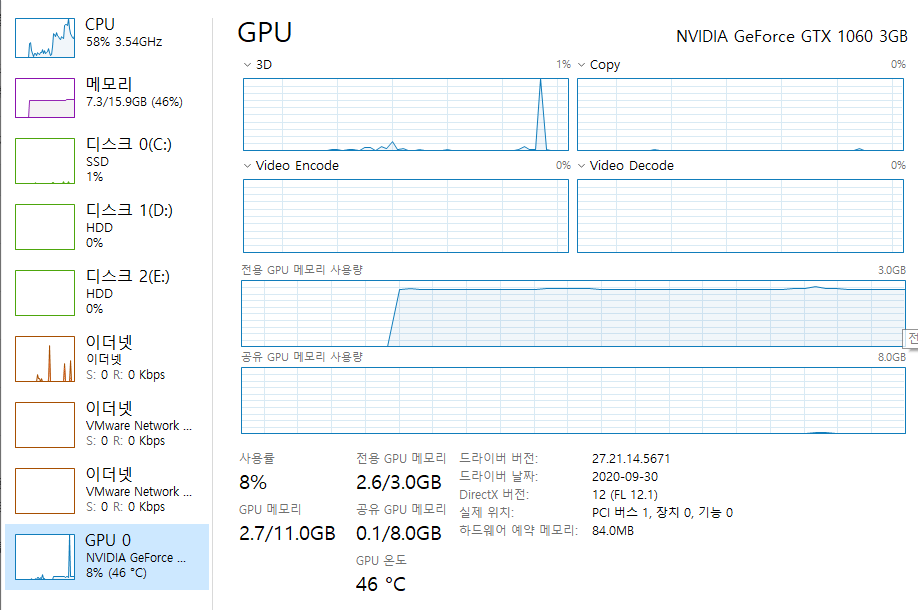
  
    에포크 1000번 돌리는데 32.9초밖에 안걸렸다 

In [34]:
# history 객체에 저장된 통계치를 사용해 모델의 훈련과정을 시각화 해보자.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.348827,1.202702,3.348827,9.070103,2.304865,9.070103,995
996,3.275295,1.224723,3.275295,8.651361,2.230045,8.651361,996
997,3.094313,1.178110,3.094313,9.023438,2.294531,9.023438,997
998,3.202894,1.222118,3.202894,8.862696,2.256748,8.862696,998
999,3.115829,1.183743,3.115829,8.698862,2.236266,8.698862,999


C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


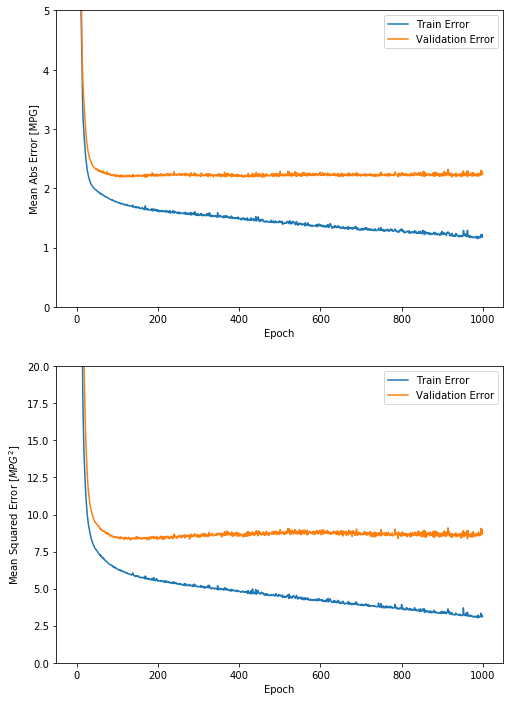

In [37]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(8, 12))
    
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Validation Error')
    plt.ylim([0, 5])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Validation Error')
    plt.ylim([0, 20])
    plt.legend()
    plt.show()

plot_history(history)

    그래프 보면 에러가 검증에러/훈련에러 차이가 커지고 있음.
    과적합 발생우려.
    과적합 막으려면 커지려고 할때 즈음 stop하는게 좋아보임.
    
    이를 EarlyStopping Callback을 사용한다고 함.


....................................................................................................
.............

C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


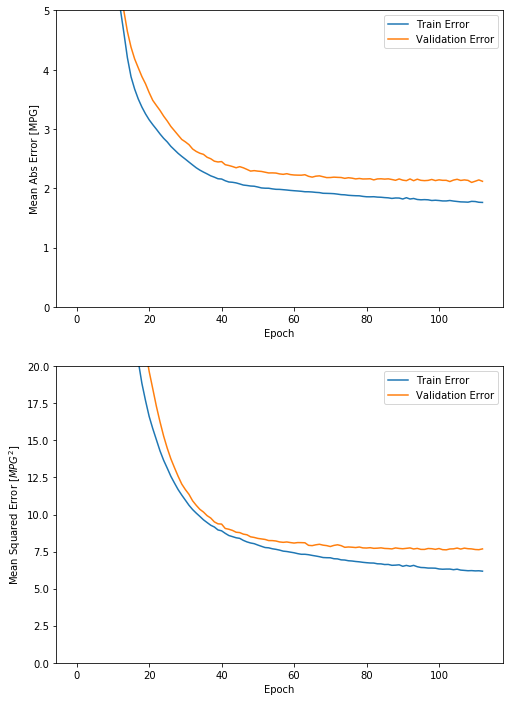

In [38]:
with tf.device('/GPU:0'):
    def build_model():
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=[len(train_set.keys())]),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
        optimizer = keras.optimizers.Adam(0.001) # 학습률 0.001
        
        model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
        return model
    model = build_model()
    
    # 에포크가 끝날때마다 점을 출력해 훈련 진행과정을 봐보자.
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
    
    # patience는 성능 향상을 체크할 에포크 횟수.
    # 즉, 10 에포크마다 확인한다는 소리.
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    history = model.fit(normed_train_data, train_labels, epochs=1000, 
                        validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

    오 개쩐다...

    테스트 셋에 대한 모델의 성능을 평가해보자.

In [40]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print('테스트 set에 대한 평균 절대 오차는 {:5.2f} MPG'.format(mae))

3/3 - 0s - loss: 5.9706 - mae: 1.9166 - mse: 5.9706
테스트 set에 대한 평균 절대 오차는  1.92 MPG


### Prediction

<br>

- 테스트 set에 있는 샘플을 이용해 MPG 값을 예측해보자.

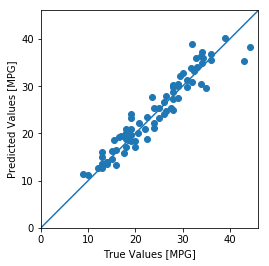

In [41]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predicted Values [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.xlim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

plt.show()

    상당히 잘 예측한 것으로 보인다.
    
    오차의 분포는 어떤지 한번 살펴보자.

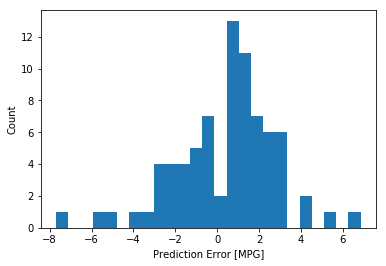

In [42]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

plt.show()

    오차가 거의 완벽한 정규분포를 따르는 것으로 보이진 않음.
    훈련 샘플 수가 매우 작아서 그런 경우인 듯 하다.

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


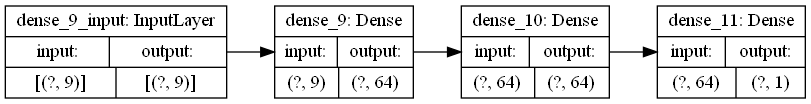

In [44]:
keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

### Conclusion

<br>

- **평균제곱오차(MSE)**는 회귀문제에서 사용하는 **손실함수**. (분류문제랑은 다름!!)
- **평균절대오차(MAE)**는 회귀 문제에서 사용하는 **평가 지표**.
- 수치 입력 데이터 특성들의 범위가 많이 달랐음. 이를 위해선 **특성의 스케일링**을 해줘야 한다.
- 훈련 데이터가 많지 않다면 **과대적합을 피하기 위해 층 갯수가 적은 소규모 네트워크를 사용**하는 것이 좋다.
- 앞서 사용한 **Early Stopping은 과대적합을 피하기 위한 방법** 중 하나.